# NOTE : This is a Python notebook !!! 
We check numerically that the state evolution overlaps correspond to the numerics

In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model
from tqdm import tqdm

import uncertaintyutils.data as data
import uncertaintyutils.erm as erm
import uncertaintyutils.utility as utility

import gcmpyo3

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Computation with constant lambda

In [25]:
lambda_ = 1.0 # other option is 0.0001

const_lambda_input_files = {
    "bootstrap_bootstrap" : f"../data/ridge/ridge_bootstrap_bootstrap_overlaps_lambda={lambda_}.json",
    "bootstrap_full"      : f"../data/ridge/ridge_bootstrap_full_overlaps_lambda={lambda_}.json",
    "full_full"           : f"../data/ridge/ridge_full_full_overlaps_lambda={lambda_}.json",
    "y_resampling"        : f"../data/ridge/ridge_y_resampling_overlaps_lambda={lambda_}.json",
    "residual_bootstrap"  : f"../data/ridge/ridge_residual_bootstrap_overlaps_lambda={lambda_}.json",
}

const_lambda_overlaps = {}

for key in const_lambda_input_files:
    with open(const_lambda_input_files[key], "r") as f:
        const_lambda_overlaps[key] = json.load(f)

In [41]:
np.random.seed(0)

dimension = 250
alpha_range = np.arange(0.5, 5.0, 0.2)
nalpha = len(alpha_range)
sigma = 1.0

bootstrap_full_correlation = np.zeros(nalpha)
bootstrap_bootstrap_correlation = np.zeros(nalpha)
full_full_correlation = np.zeros(nalpha)

wstar = data.sample_teacher(np.eye(dimension))

for i, alpha in tqdm(enumerate(alpha_range)):
    # run the bootstrap twice and erm on the full dataset once, compare with the overlaps
    n = int(dimension * alpha)
    x     = np.random.normal(size=(n, dimension)) / np.sqrt(dimension)
    y     = x @ wstar + np.random.normal(size=n) * sigma
    xprime= np.random.normal(size=(n, dimension)) / np.sqrt(dimension)
    yprime= xprime @ wstar + np.random.normal(size=n) * sigma

    w_poisson = erm.bootstrap_ridge_regression.poisson_ridge_regression(x, y, lambda_, n_resamples = 2)
    werm      = linear_model.Ridge(alpha = lambda_).fit(x, y).coef_
    wermprime = linear_model.Ridge(alpha = lambda_).fit(xprime, yprime).coef_

    bootstrap_full_correlation[i] = w_poisson[0] @ werm / dimension
    bootstrap_bootstrap_correlation[i] = w_poisson[0] @ w_poisson[1] / dimension
    full_full_correlation[i] = wermprime @ werm / dimension

23it [00:47,  2.07s/it]


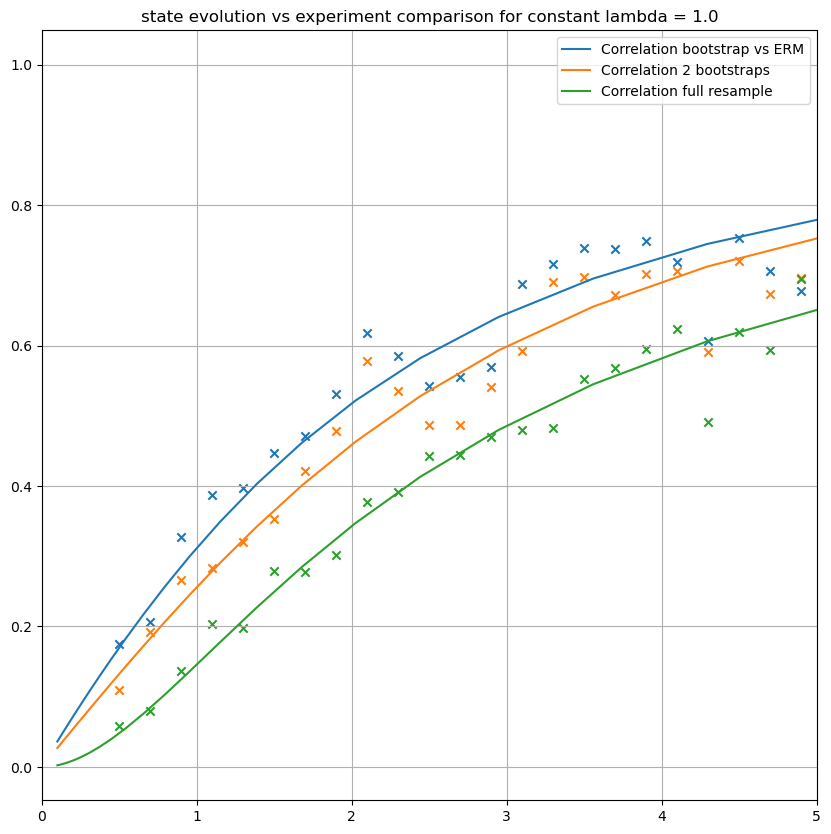

In [43]:
plt.figure(figsize=(10, 10))

plt.plot(const_lambda_overlaps["bootstrap_full"]["alpha"], const_lambda_overlaps["bootstrap_full"]["q_off_diag"], label="Correlation bootstrap vs ERM")
plt.plot(const_lambda_overlaps["bootstrap_bootstrap"]["alpha"], const_lambda_overlaps["bootstrap_bootstrap"]["q_off_diag"], label="Correlation 2 bootstraps")
plt.plot(const_lambda_overlaps["full_full"]["alpha"], const_lambda_overlaps["full_full"]["q_off_diag"], label="Correlation full resample")

plt.scatter(alpha_range, bootstrap_full_correlation, marker='x')
plt.scatter(alpha_range, bootstrap_bootstrap_correlation,  marker='x')
plt.scatter(alpha_range, full_full_correlation, marker='x')

plt.xlim(0.0, 5.0)

plt.legend()
plt.grid()
plt.title(f"state evolution vs experiment comparison for constant lambda = {lambda_}")
plt.show()

## Verification of residual bootstrap

1) Train ERM, compute the training error => compare with prediction of test error
2) Train 2 estimators on ERM-generated data => compare with prediction of overlaps

In [26]:
np.random.seed(0)

dimension = 512
alpha_range = np.arange(0.5, 5.0, 0.25)
nalpha = len(alpha_range)
sigma = 1.0

train_errors = []

erm_norms = []
residual_norms = []
correlations = []

wstar = data.sample_teacher(np.eye(dimension))

for i, alpha in tqdm(enumerate(alpha_range)):
    # run the bootstrap twice and erm on the full dataset once, compare with the overlaps
    n = int(dimension * alpha)
    x     = np.random.normal(size=(n, dimension)) / np.sqrt(dimension)
    y     = x @ wstar + np.random.normal(size=n) * sigma
    werm      = linear_model.Ridge(alpha = lambda_).fit(x, y).coef_
    erm_norms.append(np.linalg.norm(werm)**2/ dimension)
    train_error = np.mean((x @ werm - y)**2)
    train_errors.append(train_error)

    sigma_hat = np.sqrt(train_error)
    y2 = x @ werm + np.random.normal(size=n) * sigma_hat
    werm2 = linear_model.Ridge(alpha = lambda_).fit(x, y2).coef_
    y1 = x @ werm + np.random.normal(size=n) * sigma_hat
    werm1 = linear_model.Ridge(alpha = lambda_).fit(x, y1).coef_

    residual_norms.append(np.linalg.norm(werm1)**2/ dimension)
    correlations.append(werm1 @ werm2 / dimension)

18it [00:27,  1.54s/it]


In [27]:
def get_train_error(m, q, v, noise_variance):
    return (1.0 - 2 * m + q + noise_variance) / (1.0 + v)**2 

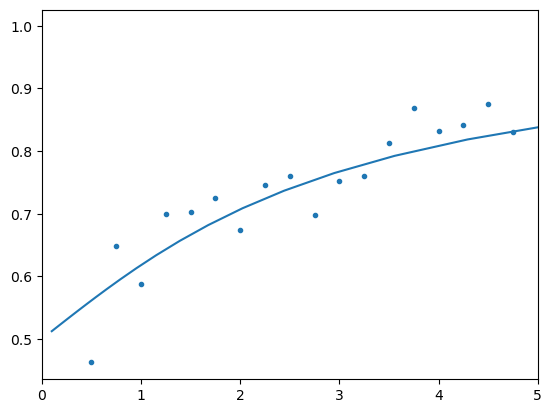

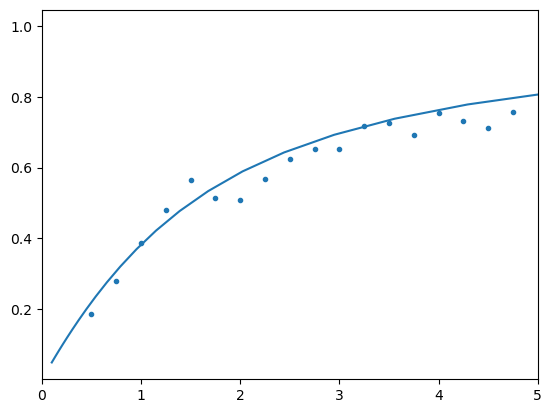

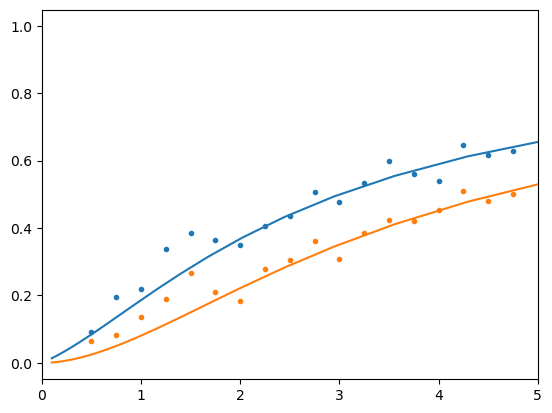

In [29]:
plt.scatter(alpha_range, train_errors, label="Train error", marker='.')
plt.plot(const_lambda_overlaps["full_full"]["alpha"], get_train_error(
    np.array(const_lambda_overlaps["full_full"]["m"]), 
    np.array(const_lambda_overlaps["full_full"]["q_diag"]), 
    np.array(const_lambda_overlaps["full_full"]["v"]), 
    sigma**2
), label="State evolution prediction")

plt.xlim(0.0, 5.0)
plt.show()

plt.scatter(alpha_range, erm_norms, label="Norm of ERM", marker='.')
plt.plot(const_lambda_overlaps["residual_bootstrap"]["alpha"], const_lambda_overlaps["residual_bootstrap"]["q"]    , label="State evolution prediction")
plt.xlim(0.0, 5.0)
plt.show()

plt.plot(const_lambda_overlaps["residual_bootstrap"]["alpha"], const_lambda_overlaps["residual_bootstrap"]["q_diag_residual"]    , label="State evolution prediction")
plt.scatter(alpha_range, residual_norms, label="Norm of residual", marker='.')

plt.plot(const_lambda_overlaps["residual_bootstrap"]["alpha"], const_lambda_overlaps["residual_bootstrap"]["q_off_diag_residual"], label="State evolution prediction")
plt.scatter(alpha_range, correlations, label="Correlation", marker='.')

plt.xlim(0.0, 5.0)
plt.show()